<a href="https://colab.research.google.com/github/victoriaprestes/ifood-data-analyst-case/blob/main/iFood_Data_Analyst_Case_An_Exploratory_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entendendo o dataset


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
from sklearn.impute import KNNImputer
from scipy.stats.mstats import winsorize

In [ ]:
project_data = pd.read_csv('project_data.csv')
ifood_df = project_data.copy()
ifood_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

# Lidando com nulos e outliers


In [ ]:
# Via de regra, se os nulos forem até 5% dos dados, podemos simplesmente deletá-los.
lim = len(ifood_df) * 0.05
to_drop = ifood_df.columns[(ifood_df.isna().sum() < lim) & (ifood_df.isna().sum() > 0)]
ifood_df.dropna(subset=to_drop, inplace=True)
ifood_df.columns.isna().sum()

0

In [ ]:
ifood_df['Income'].describe()

,Income
count,2216.000000
mean,52247.251354
std,25173.076661
min,1730.000000
25%,35303.000000
50%,51381.500000
75%,68522.000000
max,666666.000000


Aqui já encontro outro problema: os valores máximo e mínimos diferem muito do esperado, claramente outliers.
Consequentemente, usar a média está fora de questão, visto que ela é altamente influenciada por esses valores.



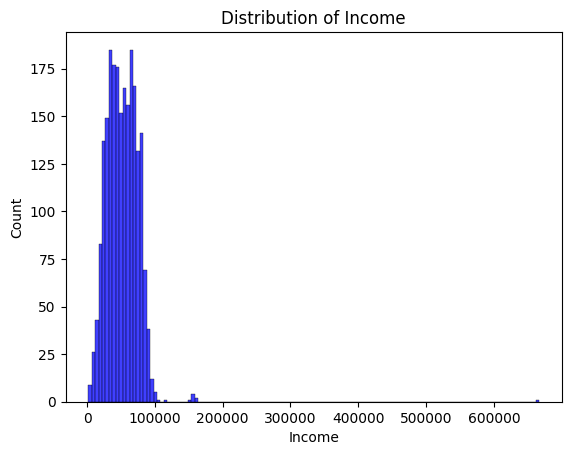

In [ ]:
#Verificando a distribuição dos dados
sns.histplot(data=ifood_df, x='Income', fill=True, color='b')
plt.xlabel('Income')
plt.title('Distribution of Income')
plt.show()

In [ ]:
def limites(df, variavel):
    q1 = df[variavel].quantile(0.25)
    q3 = df[variavel].quantile(0.75)
    iqr = q3-q1
    limite = 3*iqr
    limite_inferior = q1-limite
    limite_superior = q3+limite
    return limite_inferior, limite_superior


limite_inferior, limite_superior = limites(ifood_df, 'Income')
print('Limite superior: ', limite_superior)
print('Limite inferior: ', limite_inferior)

Limite superior:  168179.0
Limite inferior:  -64354.0


In [ ]:
#Verificando qual quantil está mais perto do limite superior
print('1% quantil:   ', ifood_df['Income'].quantile(0.01))
print('5% quantil:   ', ifood_df['Income'].quantile(0.05))
print('95% quantil:   ', ifood_df['Income'].quantile(0.95))
print('99.9% quantil: ', ifood_df['Income'].quantile(0.99))

1% quantil:    7579.200000000001
5% quantil:    18985.5
95% quantil:    84130.0
99.9% quantil:  94458.79999999999


Como o dataset não possui uma moeda, vou usar um pouco do senso comum pra verificar os valores "estranhos" que temos nessa coluna.  
Se dividirmos por 12 meses, o mínimo valor possível para um salário que faça sentido nesse contexto seria de 10.000;  o quantil que mais chega perto é o de 1%; semelhantemente, o quantil que mais chega perto nos valores alto é o de 99%

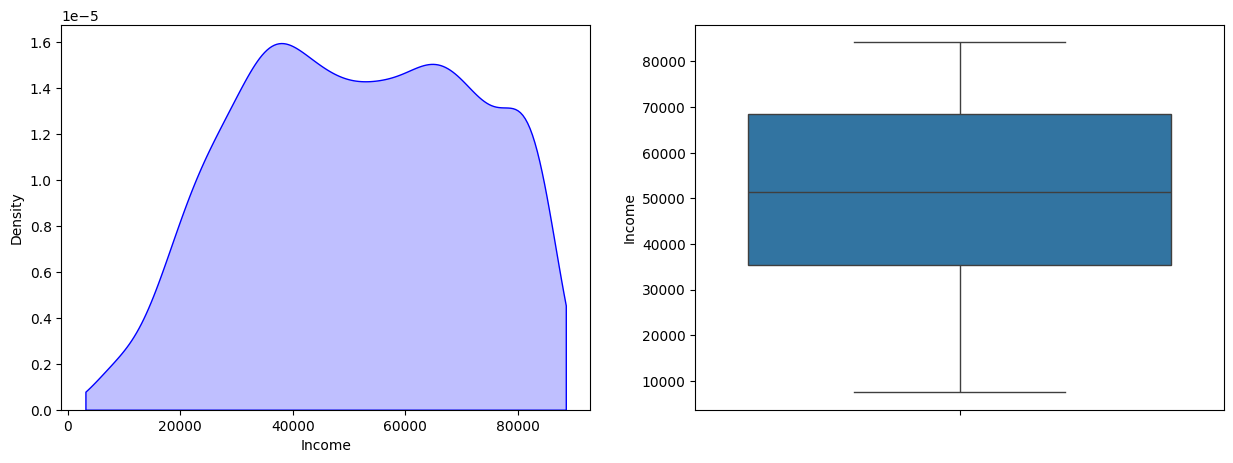

In [ ]:
ifood_df['Income'] = winsorize(ifood_df['Income'], limits=(0.01, 0.05), nan_policy='omit')
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.kdeplot(data=ifood_df, x='Income', fill=True, color='b', ax=ax[0], cut=1)
sns.boxplot(data=ifood_df['Income'], ax=ax[1])
plt.show()

In [ ]:
print(ifood_df['Income'].nsmallest(5))
print(ifood_df['Income'].nlargest(5))

9     7500.0
11    7500.0
21    7500.0
44    7500.0
46    7500.0
Name: Income, dtype: float64
29     84169.0
67     84169.0
102    84169.0
104    84169.0
109    84169.0
Name: Income, dtype: float64


Por último, vou checar duplicatas

In [ ]:
duplicated_vals =  ifood_df.duplicated(keep='last')
print('Número de duplicatas: ', duplicated_vals.sum())

Número de duplicatas:  0


Perfeito. Agora que o dataset está limpo, vou fazer algumas alterações





In [ ]:
ifood_df.set_index('ID', inplace=True)

In [ ]:
ifood_df['CustomerAge'] = pd.Timestamp('now').year - ifood_df['Year_Birth']
ifood_df.drop(columns='Year_Birth', axis=1, inplace=True)

In [ ]:
ifood_df['Dt_Customer'] = pd.to_datetime(ifood_df['Dt_Customer'])
ifood_df['CustomerYears'] = pd.Timestamp('now').year - ifood_df['Dt_Customer'].dt.year
ifood_df.drop(columns='Dt_Customer', axis=1, inplace=True)

for column in ['CustomerAge', 'CustomerYears']:
  ifood_df[column] = ifood_df[column].astype('int64')


In [ ]:
ifood_df['MntRegularProds'] = ifood_df[['MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts']].sum(axis=1)
ifood_df.drop(columns=['MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts'], axis=1, inplace=True)
ifood_df['MntRegularProds'].head()

,MntRegularProds
ID,
5524,1529
2174,21
4141,734
6182,48
5324,407


In [ ]:
for column in ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'Complain']:
  ifood_df[column] = ifood_df[column].astype('bool')


In [ ]:
ifood_df['Marital_Status'] = ifood_df['Marital_Status'].replace(['Alone', 'Absurd', 'YOLO'],'Single')
ifood_df['Marital_Status'] = ifood_df['Marital_Status'].replace('Together', 'Married')

In [ ]:
#Ajeitando a ordem das colunas pra facilitar a leitura
ifood_df = ifood_df[['Education', 'Marital_Status', 'Income','Kidhome', 'Teenhome', 'CustomerYears', 'CustomerAge',
       'Recency','Complain', 'Response', 'AcceptedCmp1', 'AcceptedCmp2',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',  'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'MntRegularProds', 'MntGoldProds','Z_CostContact', 'Z_Revenue']]
ifood_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 5524 to 9405
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2216 non-null   object 
 1   Marital_Status       2216 non-null   object 
 2   Income               2216 non-null   float64
 3   Kidhome              2216 non-null   int64  
 4   Teenhome             2216 non-null   int64  
 5   CustomerYears        2216 non-null   int64  
 6   CustomerAge          2216 non-null   int64  
 7   Recency              2216 non-null   int64  
 8   Complain             2216 non-null   bool   
 9   Response             2216 non-null   bool   
 10  AcceptedCmp1         2216 non-null   bool   
 11  AcceptedCmp2         2216 non-null   bool   
 12  AcceptedCmp3         2216 non-null   bool   
 13  AcceptedCmp4         2216 non-null   bool   
 14  AcceptedCmp5         2216 non-null   bool   
 15  NumDealsPurchases    2216 non-null   int

#Distribuição dos dados


*   A maioria dos entrevistados está na faixa 45-55 anos;
*   No geral, a maior parte dos entrevistados fez até cinco compras nos últimos 2 anos;
* Foi gasto muito mais em produtos regulares do que em produtos ouro

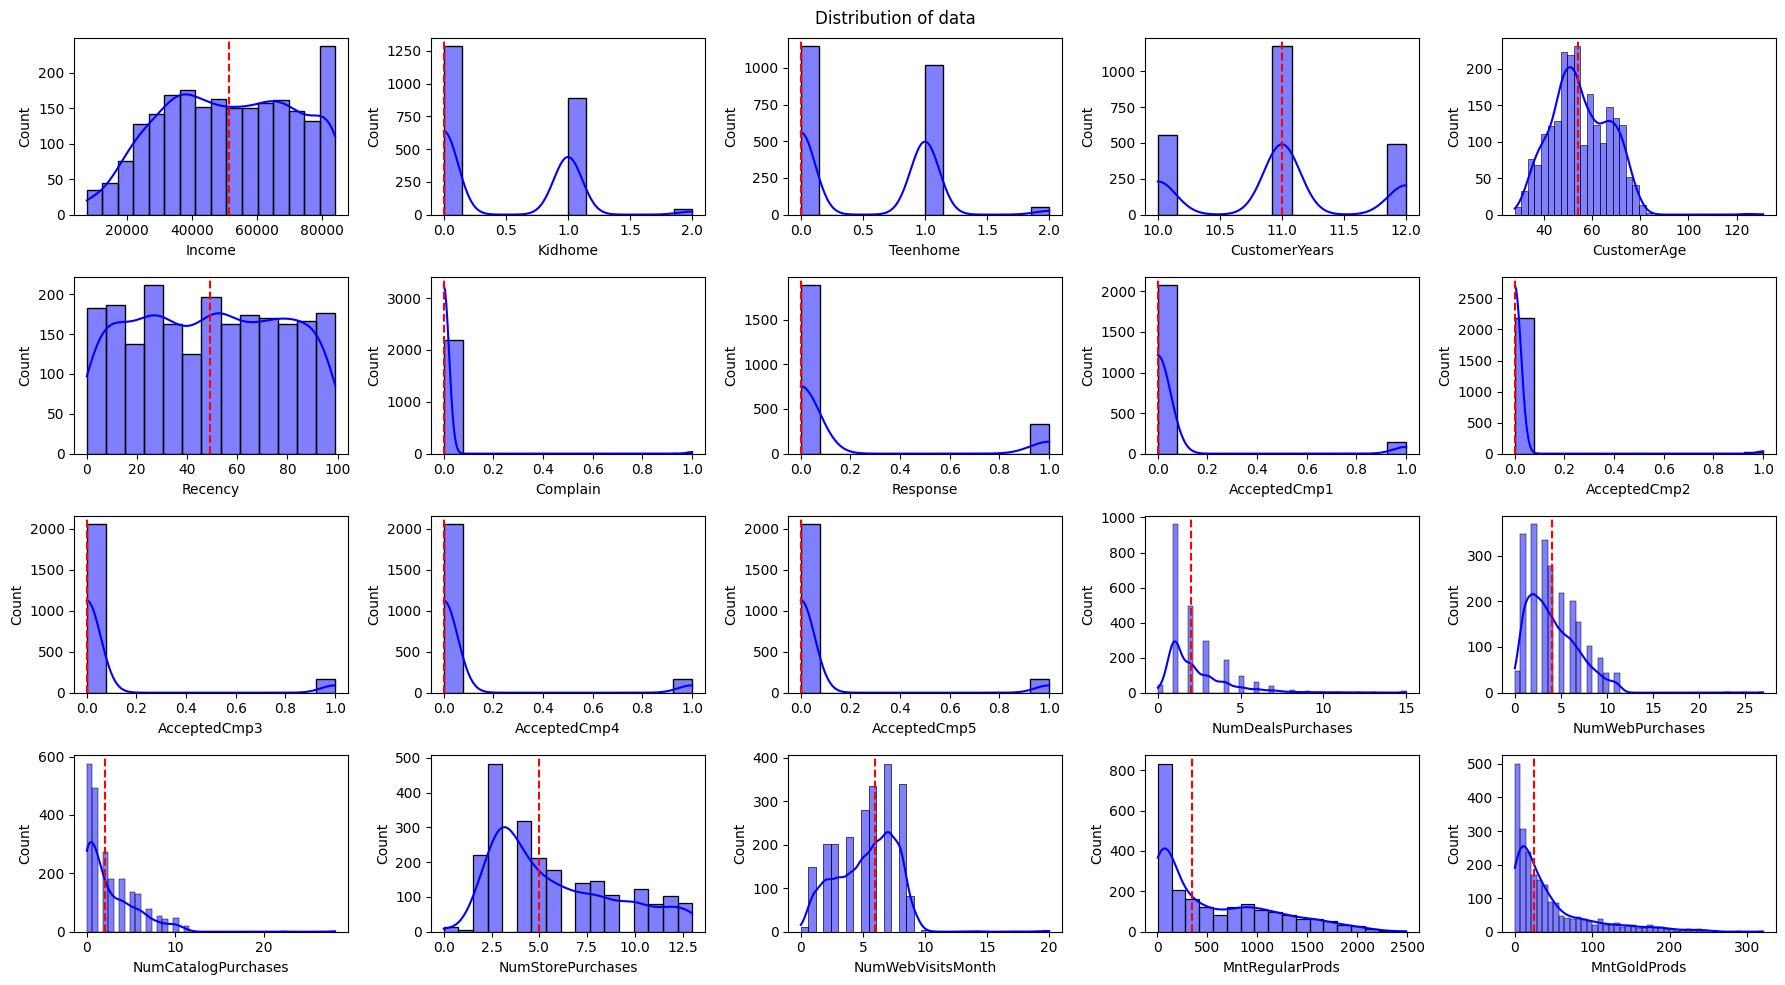

In [ ]:
numeric = ifood_df.select_dtypes(include=['int64','bool', 'float64'])
numeric.drop(columns=['Z_CostContact', 'Z_Revenue'], axis=1, inplace=True)

fig, ax = plt.subplots(4,5, figsize=(18, 10))


for i,col in enumerate(numeric.columns):
      row = i // 5
      col_num = i % 5
      sns.histplot(data=ifood_df, x=col,kde=True,color='b',ax=ax[row, col_num])
      ax[row,col_num].axvline(ifood_df[col].median(), color='r', linestyle='--')
plt.suptitle('Distribution of data')
plt.tight_layout()
plt.show()

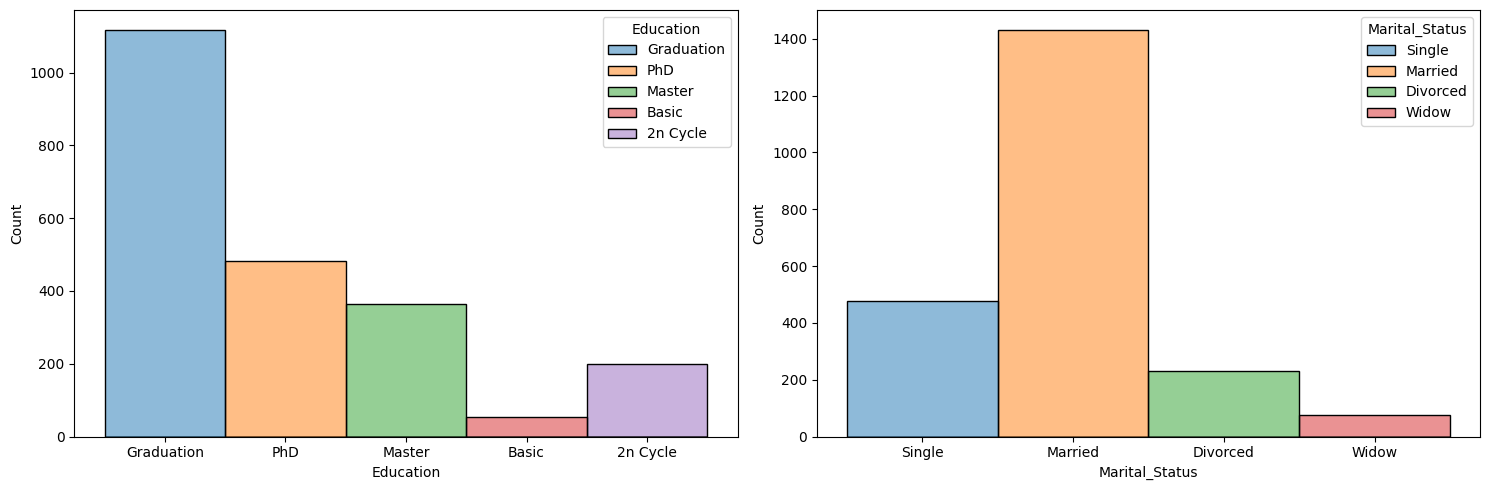

In [ ]:
# Olhando a distribuição das variáveis categóricas
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.histplot(data = ifood_df, x=ifood_df['Education'], hue='Education', ax=ax[0])
sns.histplot(data=ifood_df, x=ifood_df['Marital_Status'],hue='Marital_Status', ax=ax[1])
plt.tight_layout()
plt.show()

## Verificando Correlação

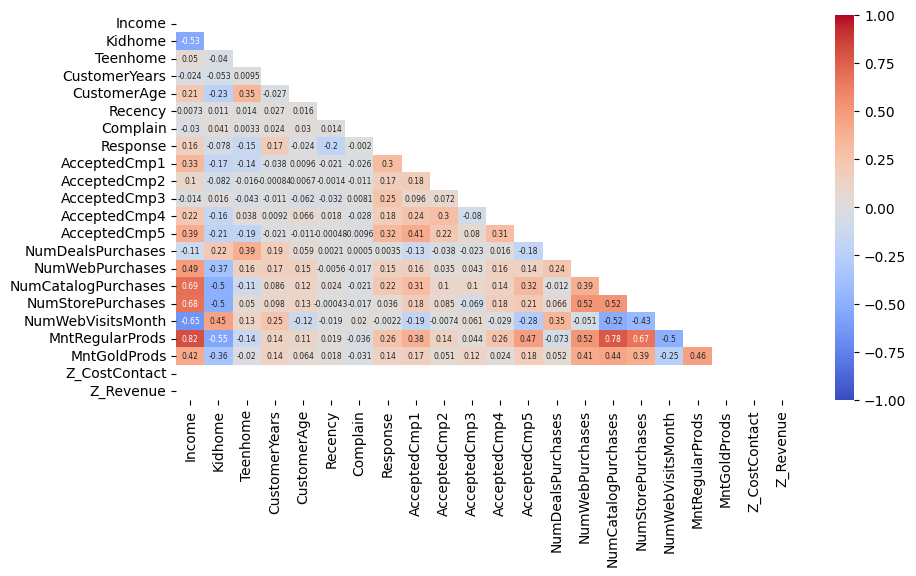

In [ ]:
mask = np.triu(np.ones_like(ifood_df.corr(numeric_only=True)))

plt.figure(figsize=(10, 5))
sns.heatmap(ifood_df.corr(numeric_only=True), cmap='coolwarm', center=0, vmin=-1, vmax=1,
                      annot=True, mask=mask, annot_kws={'size': 5.5})
plt.show()

No geral, as únicas correlações relevantes são entre MntRegularProds x TotalPurchases e MntRegularProds x Income. Vamos olhar mais a fundo

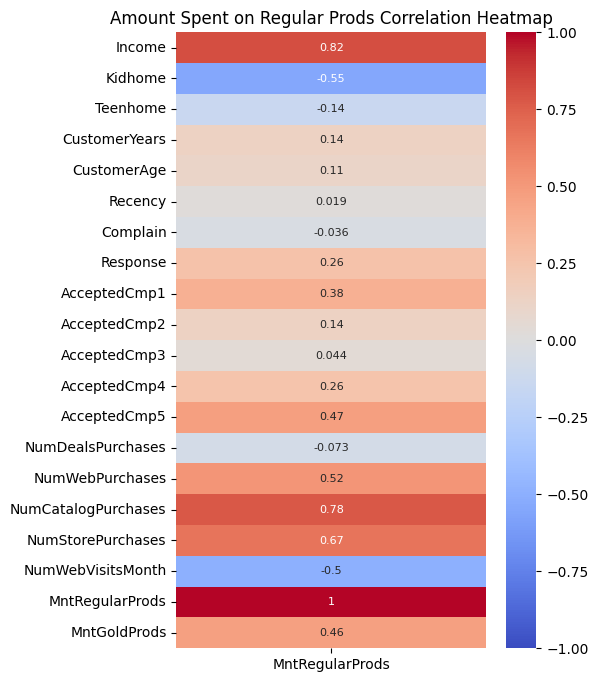

In [ ]:
income_corr = ifood_df.corr(numeric_only=True)['MntRegularProds'].to_frame().drop(['Z_CostContact', 'Z_Revenue'])
plt.figure(figsize=(5, 8))
sns.heatmap(income_corr, cmap='coolwarm', center=0, vmin=-1, vmax=1,
            annot=True, annot_kws={'size': 8})
plt.title("Amount Spent on Regular Prods Correlation Heatmap")
plt.show()

Analisando o mapa de calor, vemos que o tanto gasto em produtos regulares está fortemente correlacionado ao tanto de compras feitas diretamente pelo catálogo e levemente correlacionado ao tanto de compras feitas pela loja. Além disso, a maior correlação está com o salário anual, indicando que quanto maior o salário, maior o gasto nesses produtos.

In [ ]:
# Quero ver quanto foi gasto em cada categoria de produtos, separado pelos  diferentes canais de venda.

def calculate_total_spent(df, product_col, channel_col):
  return (df[product_col] * df[channel_col]).sum()

product_cols = ['MntRegularProds', 'MntGoldProds']
channel_cols = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']

results = {}

for product_col in product_cols:
  results[product_col] = {}

  for channel_col in channel_cols:
    results[product_col][channel_col] = calculate_total_spent(ifood_df, product_col, channel_col)

spending_by_channel = pd.DataFrame(results).T
spending_by_channel.columns = ['Web', 'Catalog', 'Store']


spending_by_channel

,Web,Catalog,Store
MntRegularProds,6905999,6234895,10024660
MntGoldProds,526073,408844,710375


Na tabela, consigo ver que os produtos regulares foram os mais vendidos no geral e que ambos os tipos de produtos vendem muito mais nas lojas, seguidos das vendas na web e por último no catálogo.

Agora eu quero focar no cliente: quais são os tipos de cliente que temos e que tipo de produtos eles consomem?
Pra fazer isso, vou segmentá-los baseado em: salário, gasto e canal de compra.


In [ ]:
# Criando as novas colunas
ifood_df['high_income'] = ifood_df['Income'] >= 70000
ifood_df['medium_income'] = (ifood_df['Income'] > 30000) & (ifood_df['Income'] < 70000)
ifood_df['low_income'] = ifood_df['Income'] <= 30000



In [ ]:
# Como pretendo comparar várias métricas com salário, o código vai ficar muito longo e confuso, então pra facilitar a leitura, vou criar algumas funções.


def high_income_melt(value_vars, var_name, value_name):
  # Cria uma tabela em que 'high_income' é o ID com tipo de produto e valor como colunas
  melted = pd.melt(ifood_df, id_vars=['high_income'], value_vars=value_vars, var_name=var_name, value_name=value_name)
  return melted[melted['high_income'] == True]

def medium_income_melt(value_vars, var_name, value_name):
 # Cria uma tabela em que 'medium_income' é o ID com tipo de produto e valor como colunas
  melted = pd.melt(ifood_df, id_vars=['medium_income'], value_vars=value_vars, var_name=var_name, value_name=value_name)
  return melted[melted['medium_income'] == True]

def low_income_melt(value_vars, var_name, value_name):
 # Cria uma tabela em que 'low_income' é o ID com tipo de produto e valor como colunas
  melted = pd.melt(ifood_df, id_vars=['low_income'], value_vars=value_vars, var_name=var_name, value_name=value_name)
  return melted[melted['low_income'] == True]


def plot_income(x_col, y_col, df_list, hue_col, *args, **kwargs):
# Cria uma figura com o gráfico de barras de cada intervalo salarial.
  fig, ax = plt.subplots(1,3, **kwargs, sharey=True)
  titles = ['High Income', 'Medium Income', 'Low Income']
  for i, df in enumerate(df_list):
    sns.barplot(x=x_col, y=y_col, data=df, hue=hue_col, ax=ax[i])
    ax[i].set_title(titles[i])
  plt.suptitle(*args)
  plt.tight_layout()
  plt.show()




In [ ]:
# Separando as classes de salário por quantidade gasta em cada produto
high_income_mnt = high_income_melt(value_vars=['MntRegularProds', 'MntGoldProds'], var_name='Product', value_name='Amount Spent')
medium_income_mnt = medium_income_melt(value_vars=['MntRegularProds', 'MntGoldProds'], var_name='Product', value_name='Amount Spent')
low_income_mnt = low_income_melt(value_vars=['MntRegularProds', 'MntGoldProds'], var_name='Product', value_name='Amount Spent')


In [ ]:
#Mudando o nome das variáveis
high_income_mnt['Product'] = high_income_mnt['Product'].replace({'MntRegularProds': 'Regular Products', 'MntGoldProds': 'Gold Products'})
medium_income_mnt['Product'] = medium_income_mnt['Product'].replace({'MntRegularProds': 'Regular Products', 'MntGoldProds': 'Gold Products'})
low_income_mnt['Product'] = low_income_mnt['Product'].replace({'MntRegularProds': 'Regular Products', 'MntGoldProds': 'Gold Products'})


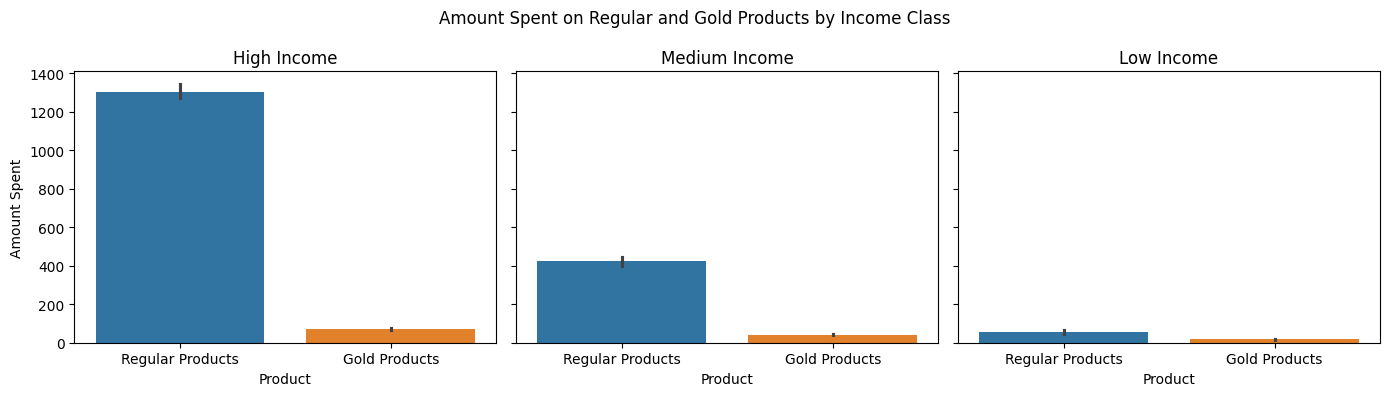

In [ ]:
plot_income('Product', 'Amount Spent', [high_income_mnt, medium_income_mnt, low_income_mnt], 'Product', 'Amount Spent on Regular and Gold Products by Income Class', figsize=(14,4))

Como esperado, os clientes que ganham mais também gastam mais.

In [ ]:
# Separando as classes de salário por local de compra
high_income_purchases = high_income_melt(value_vars=['NumWebPurchases', 'NumDealsPurchases', 'NumCatalogPurchases'], var_name='Purchase_Channel', value_name='Total_Purchases')
medium_income_purchases = medium_income_melt(value_vars=['NumWebPurchases', 'NumDealsPurchases', 'NumCatalogPurchases'], var_name='Purchase_Channel', value_name='Total_Purchases')
low_income_purchases = low_income_melt(value_vars=['NumWebPurchases', 'NumDealsPurchases', 'NumCatalogPurchases'], var_name='Purchase_Channel', value_name='Total_Purchases')



In [ ]:
#Mudando o nome das variáveis
high_income_purchases['Purchase_Channel'] = high_income_purchases['Purchase_Channel'].replace({'NumWebPurchases':'Web Purchases', 'NumDealsPurchases': 'Deals Purchases', 'NumCatalogPurchases':'Catalog Purchases'})
medium_income_purchases['Purchase_Channel'] = medium_income_purchases['Purchase_Channel'].replace({'NumWebPurchases':'Web Purchases', 'NumDealsPurchases': 'Deals Purchases', 'NumCatalogPurchases':'Catalog Purchases'})
low_income_purchases['Purchase_Channel'] = low_income_purchases['Purchase_Channel'].replace({'NumWebPurchases':'Web Purchases', 'NumDealsPurchases': 'Deals Purchases', 'NumCatalogPurchases':'Catalog Purchases'})



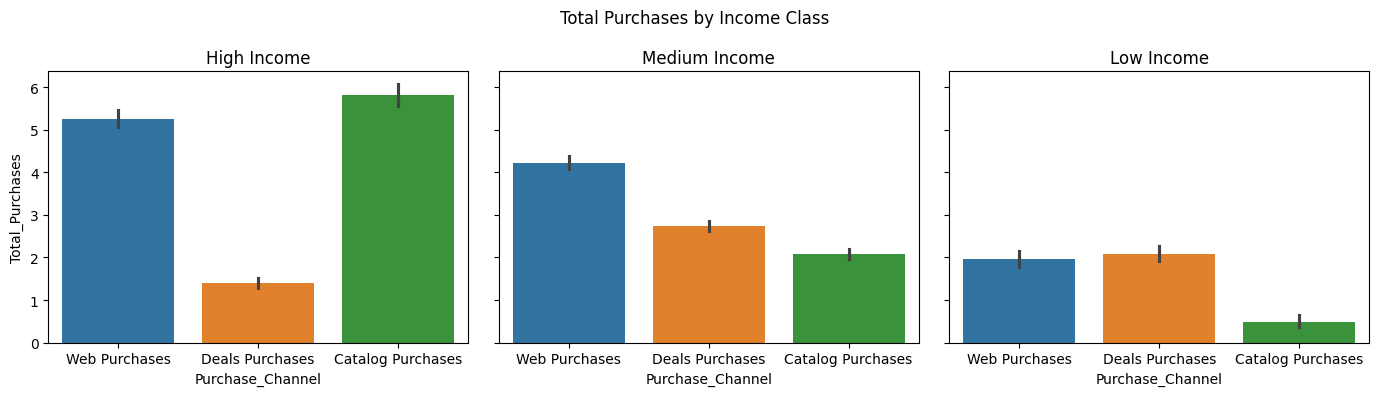

In [ ]:
plot_income('Purchase_Channel', 'Total_Purchases', [high_income_purchases, medium_income_purchases, low_income_purchases], 'Purchase_Channel', 'Total Purchases by Income Class', figsize=(14,4))

Clientes com salários maiores compram primariamente no catálogo,

In [ ]:
ifood_df['AcceptedCmp1'] = ifood_df['AcceptedCmp1'] == True
ifood_df['AcceptedCmp2'] = ifood_df['AcceptedCmp2'] == True
ifood_df['AcceptedCmp3'] = ifood_df['AcceptedCmp3'] == True
ifood_df['AcceptedCmp4'] = ifood_df['AcceptedCmp4'] == True
ifood_df['AcceptedCmp5'] = ifood_df['AcceptedCmp5'] == True


In [ ]:
high_income_acceptance = high_income_melt(value_vars=['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5'], var_name='campaign', value_name='accepted_value')
medium_income_acceptance = medium_income_melt(value_vars=['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5'], var_name='campaign', value_name='accepted_value')
low_income_acceptance = low_income_melt(value_vars=['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5'], var_name='campaign', value_name='accepted_value')



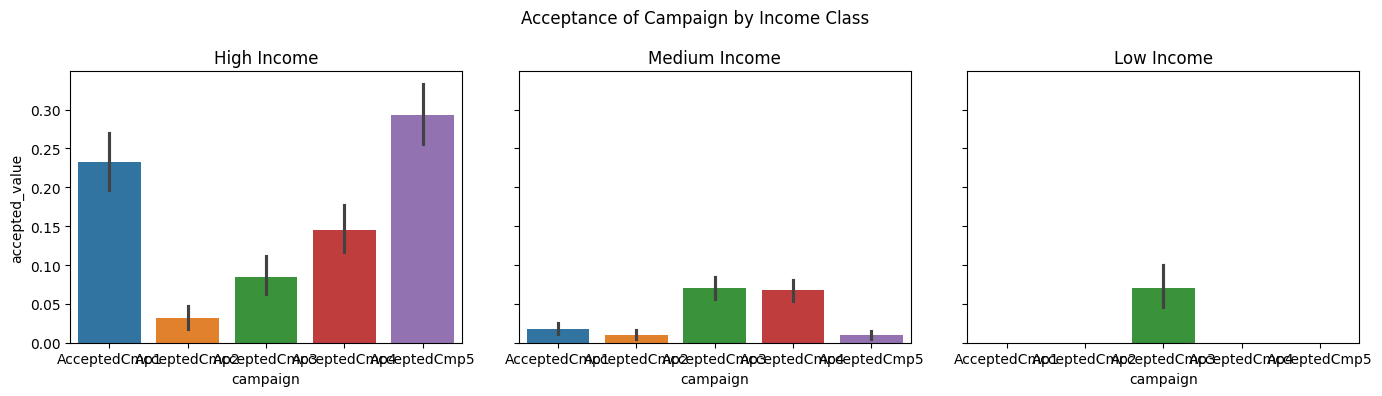

In [ ]:
plot_income('campaign', 'accepted_value',[high_income_acceptance, medium_income_acceptance, low_income_acceptance], 'campaign', 'Acceptance of Campaign by Income Class', figsize=(14,4))

cliente vip (gastam mais)
* Valor alto: >= 2000
* Valor baixo <= 500

cliente gold (gastam com prod caro)
* alto: >= 300
* baixo: <= 40

cliente pechincha
* alto: >=10
* baixo: <=10

(ver como cada tipo de cliente compra e se aceitou campanhas)


